# Create baseline model
route and origin+destination locations

In [1]:
# Select where to run notebook: "azure" or "local"
my_run = "azure"

In [2]:
import numpy as np
import pandas as pd

import shapely.ops as so
import shapely.geometry as sg
import geopandas as gpd

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import contextily as cx

import networkx as nx
import momepy

import settings as st
if my_run == "azure":
    import config_azure as cf
elif my_run == "local":
    import config as cf

/mnt/batch/tasks/shared/LS_root/mounts/clusters/tutorials-compute/code/Users/shayla.jansen/Accessible_Route_Planning/venv_rp/lib/python3.8/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


## Get network data

In [3]:
# Get basic pedestrian network with widths
df = gpd.read_file(cf.output_file_widths)
df.head(3)

,cl_id,length,sidewalk_id,obstacle_free_width,geometry
0,0,0.856342,0,None,"LINESTRING (114335.503 485523.413, 114335.766 ..."
1,1,1.990000,0,1.5-2.0m,"LINESTRING (114336.060 485524.041, 114336.115 ..."
2,1,1.990000,0,1.5-2.0m,"LINESTRING (114336.871 485525.837, 114336.893 ..."


In [4]:
# Create graph
G = momepy.gdf_to_nx(df, approach="primal", multigraph=True)

## Get start and end location

In [5]:
#df_coords = pd.DataFrame({"coordinates": ["origin", "destination"],
#        "latitude": [52.35334092728026, 52.3530251803945],
#        "longitude": [4.794123653644032, 4.795162914332731]})
#
#df_coords = pd.DataFrame({"coordinates": ["origin", "destination"],
#        "latitude": [52.357453149357, 52.35728713372162],
#        "longitude": [4.793142721280574, 4.793296733304029]})

df_coords = pd.DataFrame({"coordinates": ["origin", "destination"],
        "latitude": [52.358259455484855, 52.35716683958979],
        "longitude": [4.791934580267541, 4.7926534122913855]})

In [6]:
gdf_coords = gpd.GeoDataFrame(
    df_coords, geometry=gpd.points_from_xy(df_coords.longitude, df_coords.latitude), crs="EPSG:4326"
)
gdf_coords = gdf_coords.to_crs(st.CRS)
gdf_coords = gdf_coords[['coordinates', 'geometry']]

## Create objective

In [7]:
# Create input column for weight based on width
min_width = 2.1  # based on user profile

df['accessible_width'] = 10000
if min_width <= 0.9:
    df.loc[df['obstacle_free_width'].isin(['0.9-1.5m']), 'accessible_width'] = 1.5
    df.loc[df['obstacle_free_width'].isin(['1.5-2.0m', '2.0-2.2m', '2.2-2.9m', '2.9-3.6m', '>3.6m']), 'accessible_width'] = 1
elif (min_width > 0.9) & (min_width <= 1.5):
    df.loc[df['obstacle_free_width'].isin(['1.5-2.0m']), 'accessible_width'] = 1.5
    df.loc[df['obstacle_free_width'].isin(['2.0-2.2m', '2.2-2.9m', '2.9-3.6m', '>3.6m']), 'accessible_width'] = 1
elif (min_width > 1.5) & (min_width <= 2.0):
    df.loc[df['obstacle_free_width'].isin(['2.0-2.2m']), 'accessible_width'] = 1.5
    df.loc[df['obstacle_free_width'].isin(['2.2-2.9m', '2.9-3.6m', '>3.6m']), 'accessible_width'] = 1
elif (min_width > 2.0) & (min_width <= 2.2):
    df.loc[df['obstacle_free_width'].isin(['2.2-2.9m']), 'accessible_width'] = 1.5
    df.loc[df['obstacle_free_width'].isin(['2.9-3.6m', '>3.6m']), 'accessible_width'] = 1
elif (min_width > 2.2) & (min_width <= 2.9):
    df.loc[df['obstacle_free_width'].isin(['2.9-3.6m']), 'accessible_width'] = 1.5
    df.loc[df['obstacle_free_width'].isin(['>3.6m']), 'accessible_width'] = 1
elif (min_width > 2.9) & (min_width <= 3.6):
    df.loc[df['obstacle_free_width'].isin(['>3.6m']), 'accessible_width'] = 1.5

In [8]:
# Define weight (combination of objectives) -- DUMMY version for now
df['my_weight'] = df['length'] + df['accessible_width']*df['length'] 

## Get route

In [9]:
# Get origin and destination location
origin_point = gdf_coords.loc[gdf_coords['coordinates'] == 'origin', 'geometry'].values[0]
dest_point = gdf_coords.loc[gdf_coords['coordinates'] == 'destination', 'geometry'].values[0]

# Get origin and destination node location
origin_node_loc = so.nearest_points(origin_point, sg.MultiPoint(list(G.nodes)))[1]
dest_node_loc = so.nearest_points(dest_point, sg.MultiPoint(list(G.nodes)))[1]

# Get origin and destination node
origin_node = (origin_node_loc.x, origin_node_loc.y)
dest_node = (dest_node_loc.x, dest_node_loc.y)   

In [10]:
# Get 'shortest' path between origin and destination, based on custom weight
my_path = nx.shortest_path(G, origin_node, dest_node, weight='my_weight')

In [11]:
# Put 'shortest' path in a dataframe
G_path = nx.subgraph(G, my_path)
df_path = momepy.nx_to_gdf(G_path, lines=True, points=False)
df_path.head(3)

,cl_id,length,sidewalk_id,obstacle_free_width,geometry,mm_len
0,3154,1.99,65,2.2-2.9m,"LINESTRING (114464.995 485706.432, 114464.951 ...",1.99
1,3154,1.99,65,2.2-2.9m,"LINESTRING (114464.388 485708.324, 114464.339 ...",1.99
2,3154,1.99,65,2.2-2.9m,"LINESTRING (114475.940 485672.384, 114475.811 ...",1.99


## Visualize

In [12]:
# Subset network
my_rad = 100
gdf_coords['buffer'] = gdf_coords['geometry'].buffer(my_rad, cap_style=3)
plot_area = gpd.GeoDataFrame(geometry=[gdf_coords['buffer'][0].union(gdf_coords['buffer'][1])], crs=st.CRS)
df_sub = gpd.sjoin(df, plot_area, how='inner').reset_index()

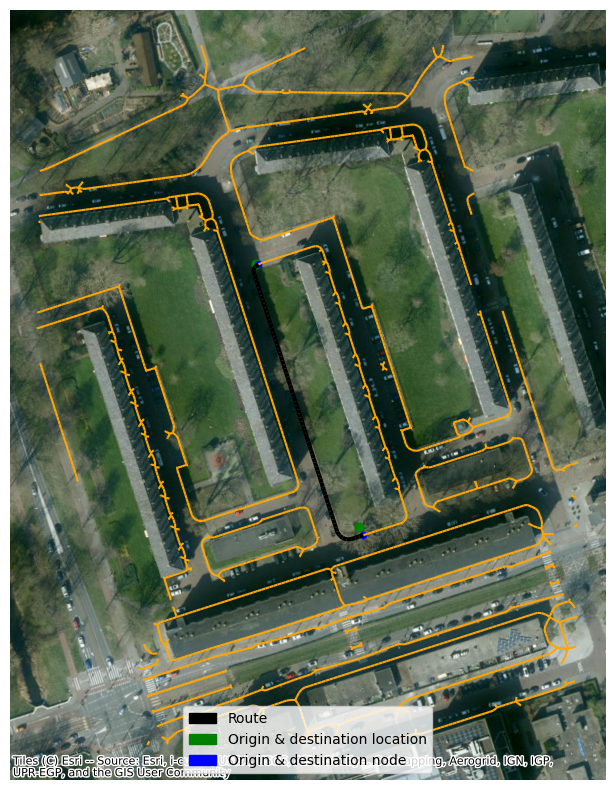

In [13]:
fig, ax = plt.subplots(figsize=(10,10))

# Network
df_sub.plot(ax=ax, color='orange')

# 'Shortest' path
df_path.plot(ax=ax, color='black', linewidth=3)

# Origin and destination location
gdf_coords.plot(ax=ax, color='green', markersize=40)

# Origin and destination nodes
gpd.GeoSeries([origin_node_loc], crs=st.CRS).plot(ax=ax, color='blue', markersize=20)
gpd.GeoSeries([dest_node_loc], crs=st.CRS).plot(ax=ax, color='blue', markersize=20)

# Background
cx.add_basemap(ax=ax, source=cx.providers.Esri.WorldImagery, crs=st.CRS)

# Legend
route = mpatches.Patch(color='black', label='Route')
loc = mpatches.Patch(color='green', label= 'Origin & destination location')
nodes = mpatches.Patch(color='blue', label= 'Origin & destination node')
plt.legend(handles=[route,loc,nodes], loc='lower center')

plt.axis('off')

#plt.savefig(test_route.png, bbox_inches='tight')
plt.show()

## Store data

In [17]:
#df_route['length'] = df_route['length'].round(2)
#df_route = df_route.to_crs('epsg:4326')
#df_route[['geometry', 'length']].to_csv('output/example_route.csv', sep=';')
#df_route[['geometry', 'length']].to_file('output/example_route.gpkg', driver='GPKG')

In [18]:
#gdf_coords = gdf_coords.to_crs('epsg:4326')
#gdf_coords.to_csv('output/example_locations.csv', sep=";")
#gdf_coords.to_file('output/example_locations.gpkg', driver='GPKG')